In [12]:
import os, logging, time, argparse, random
from datetime import timedelta

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score, mean_absolute_percentage_error)

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers import  Masking
from scipy.interpolate import UnivariateSpline,CubicSpline

logging.basicConfig(format="%(levelname)s %(message)s", level=logging.INFO)
MASK_VAL = -1.0

In [13]:
# GPU check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU device not found. Đảm bảo bạn đã chọn runtime GPU.")
else:
    print(f"Found GPU at: {device_name}")

Num GPUs Available:  1
Found GPU at: /device:GPU:0


I0000 00:00:1748321850.258871 2980524 gpu_device.cc:2019] Created device /device:GPU:0 with 1010 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
def load_and_align_data(files: dict, variables: list, mask: float = MASK_VAL):
    idx = None
    for path in files.values():
        df = pd.read_csv(path, parse_dates=['datetime'],
                         index_col='datetime').fillna(mask)
        idx = df.index if idx is None else idx.intersection(df.index)

    data, names = [], []
    for name, path in files.items():
        df = pd.read_csv(path, parse_dates=['datetime'],
                         index_col='datetime').fillna(mask)
        for var in variables:
            if var not in df.columns:
                continue
            data.append(df.loc[idx, var].tolist())
            names.append(f"{name}_{var}")
    return data, names, idx

In [15]:
def interpolate(seqs, mask: float = MASK_VAL):
    out = []
    for seq in seqs:
        arr = [np.nan if v == mask else v for v in seq]
        ser = pd.Series(arr).interpolate().fillna(method='bfill').fillna(method='ffill')
        out.append(ser.values.tolist())
    return out

def data_normalize(seqs, mask: float = MASK_VAL):
    norm, params = [], []
    for seq in seqs:
        valid = [v for v in seq if v != mask]
        mn, mx = (min(valid), max(valid)) if valid else (0.0, 1.0)
        norm.append([(v-mn)/(mx-mn) if v != mask and mx != mn else v for v in seq])
        params.append((mn, mx))
    return norm, params


def data_split(seqs, T_in, T_out, offset, stride):
    X, Y = [], []
    seq_len, n_series = len(seqs[0]), len(seqs)
    period = T_in + offset + T_out
    for i in range(0, seq_len - period + 1, stride):
        X.append([s[i : i+T_in] for s in seqs])
        Y.append([s[i+T_in+offset : i+T_in+offset+T_out] for s in seqs])
    return np.array(X), np.array(Y)


def split_train(intp, norm, T_in, T_out, offset, stride,
                split_start, split_end):
    length = len(intp[0])
    s, e = int(split_start*length), int(split_end*length)
    tr_norm   = [seq[:s] + seq[e:] for seq in norm]   # training inputs
    te_intp   = [seq[s:e]            for seq in intp] # test inputs/labels
    train_x, train_y = data_split(tr_norm, T_in, T_out, offset, stride)
    test_x , test_y  = data_split(te_intp, T_in, T_out, offset, stride)
    return train_x, train_y, test_x, test_y




In [16]:
def spatial_LSTM(X, Y, learning_rate=1e-4, patience=15,
                 epochs=100, batch_size=16, lstm_units=32):
    time_step = X.shape[1]
    input_dim = X.shape[2]
    out = Y.shape[2]
    #Bidirectional LSTM
    start = time.time()
    model = Sequential()
    model.add(Masking(mask_value=-1.,input_shape=(time_step, input_dim)))
    model.add(Bidirectional(LSTM(32,activation='elu', input_shape=(time_step, input_dim),return_sequences=True)))
    #model.add(Bidirectional(LSTM(64, activation='elu', input_shape=(time_step, input_dim), return_sequences=True)))
    #model.add(Masking(mask_value=-1.,input_shape=(time_step, input_dim)))
    model.add(Dense(out))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    hist = model.fit(X, Y,epochs=100, validation_split=.2,
              verbose=0, batch_size=10)
    model.summary()
    end = time.time()
    print("Total compile time: --------", end - start, 's')
    return model, hist

In [17]:
def train_spatial_model(data, T_in, T_out, offset, stride,
                        split_start, split_end,
                        lr=1e-4, patience=15, epochs=100,
                        batch_size=16, lstm_units=32, title="PM2.5"):
    norm, scale = data_normalize(data)
    intp        = interpolate(norm)

    # ── Heat-map for sanity-check
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); sns.heatmap(norm, cmap='viridis')
    plt.title(f'{title} – Normalised (gaps kept)')
    plt.subplot(1,2,2); sns.heatmap(intp, cmap='viridis')
    plt.title(f'{title} – After Interpolation')
    plt.tight_layout(); plt.show()

    trX,trY,teX,teY = split_train(
        intp, norm, T_in, T_out, offset, stride,
        split_start, split_end
    )
    logging.info(f"Train X {trX.shape}  Train Y {trY.shape}")
    logging.info(f"Test  X {teX.shape}   Test Y {teY.shape}")

    model, hist = spatial_LSTM(
        trX, trY, learning_rate=lr, patience=patience,
        epochs=epochs, batch_size=batch_size, lstm_units=lstm_units
    )

    # ── Loss curve
    plt.figure(); plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val'); plt.legend(); plt.show()

    preds = model.predict(teX, verbose=1)
    return preds, teY, model, scale, hist


In [18]:
def SP_Learner_multioutput(
    data_in,           # list of input sensor series
    data_out=None,     # kept for API-compatibility (ignored for now)
    train_time=300,    # T_in
    test_time=30,      # T_out
    pred_offset=120,   # gap between in/out
    stride=15,         # slide step
    start=0.8, end=1.0,# test split [start, end)
    tempor_units=64,   # (not used – see note)
    spatial_units=32,  # lstm_units we pass to spatial_LSTM
    lr=1e-4, epochs=50,
    batch_size=16, patience=15,
):

    norm_in, scale_in = data_normalize(data_in)
    intp_in           = interpolate(norm_in)

    trX, trY, teX, teY = split_train(
        intp_in, norm_in,
        train_time, test_time,
        pred_offset, stride,
        start, end
    )
    #  X  shape: (samples, sensors, train_time)
    #  Y  shape: (samples, sensors, test_time)

    logging.info(f"Train X {trX.shape}  Train Y {trY.shape}")
    logging.info(f"Test  X {teX.shape}   Test Y {teY.shape}")

    model, history = spatial_LSTM(
        trX, trY,
        learning_rate = lr,
        patience      = patience,
        epochs        = epochs,
        batch_size    = batch_size,
        lstm_units    = spatial_units     
    )

    pred_field = model.predict(teX, verbose=1)   # (samples, sensors, test_time)

    return pred_field, teY, scale_in, model, history

In [26]:
def compute_target_weights(positions, target_pos, alpha=2.0, eps=1e-6):
    coords = np.array(list(positions.values()))
    dists = np.linalg.norm(coords - np.array(target_pos), axis=1)
    w = 1.0 / (dists**alpha + eps)
    return w / w.sum()

In [20]:
# def save_predictions_to_csv(predictions: np.ndarray, filename: str, sensor_names: list = None):
#     if predictions.ndim == 1:
#         predictions = predictions.reshape(1, -1)
#     n_cols = predictions.shape[1]
#     cols = sensor_names or [f"t{i+1}" for i in range(n_cols)]
#     df = pd.DataFrame(predictions, columns=cols)
#     df.to_csv(filename, index=False)
#     logging.info(f"Saved predictions to '{filename}'")

# def evaluate_predictions(preds: np.ndarray, truths: np.ndarray):
#     p = preds.ravel()
#     t = truths.ravel()
#     mae = mean_absolute_error(t, p)
#     rmse = np.sqrt(mean_squared_error(t, p))
#     r2 = r2_score(t, p)
#     mape = mean_absolute_percentage_error(t + 1e-12, p + 1e-12) * 100
#     logging.info(f"Metrics -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%")
#     return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}


In [21]:
def plot_loss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.ylabel('Loss (MAE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    print(f"Final training loss: {final_train_loss:.4f}")
    print(f"Final validation loss: {final_val_loss:.4f}")
    print(f"Validation/Training loss ratio: {final_val_loss/final_train_loss:.2f}")

    if final_val_loss/final_train_loss > 1.2:
        print("Warning: Validation loss is significantly higher than training loss, which suggests overfitting.")
    elif final_val_loss/final_train_loss < 0.9:
        print("Note: Validation loss is lower than training loss, which suggests underfitting or data distribution differences.")

def plot_training_predictions(train_pred, ty, scaling_params):
    mn, mx = scaling_params[0]
    pred_denorm = train_pred[:, 0, 0] * (mx - mn) + mn
    actual_denorm = ty[:, 0, 0] * (mx - mn) + mn
    n_samples = min(200, len(pred_denorm))
    indices = np.linspace(0, len(pred_denorm)-1, n_samples, dtype=int)
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.scatter(actual_denorm[indices], pred_denorm[indices], alpha=0.5)
    min_val = min(np.min(actual_denorm), np.min(pred_denorm))
    max_val = max(np.max(actual_denorm), np.max(pred_denorm))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title('Predictions vs Actual Values (Training)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.subplot(2, 1, 2)
    plt.plot(actual_denorm[indices], 'b-', label='Actual')
    plt.plot(pred_denorm[indices], 'r-', label='Predicted')
    plt.title('Time Series Comparison (Training)')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    mae = mean_absolute_error(actual_denorm, pred_denorm)
    rmse = np.sqrt(mean_squared_error(actual_denorm, pred_denorm))
    r2 = r2_score(actual_denorm, pred_denorm)
    print(f"Training data metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

def analyze_indoor_outdoor_relationship(indoor_data, outdoor_data, indoor_names, outdoor_names, time_index):
    data_dict = {name: indoor_data[i] for i, name in enumerate(indoor_names)}
    data_dict.update({name: outdoor_data[i] for i, name in enumerate(outdoor_names)})
    df = pd.DataFrame(data_dict, index=time_index)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Between Indoor and Outdoor Variables')
    plt.show()

    plt.figure(figsize=(15, 6))
    for i, in_name in enumerate(indoor_names):
        if 'PM2_5' in in_name or 'PM2.5' in in_name:
            plt.plot(time_index, indoor_data[i], label=in_name)
    for i, out_name in enumerate(outdoor_names):
        plt.plot(time_index, outdoor_data[i], label=out_name, linestyle='--')
    plt.title('Indoor vs Outdoor PM2.5 Comparison')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('PM2.5 (normalized)')
    plt.grid(True)
    plt.show()

    for i, in_name in enumerate(indoor_names):
        if 'PM2_5' in in_name or 'PM2.5' in in_name:
            for j, out_name in enumerate(outdoor_names):
                indoor_series = pd.Series(indoor_data[i])
                outdoor_series = pd.Series(outdoor_data[j])
                cross_corr = [indoor_series.corr(outdoor_series.shift(lag)) for lag in range(-24, 25)]
                plt.figure(figsize=(12, 5))
                plt.plot(range(-24, 25), cross_corr)
                plt.axvline(x=0, color='r', linestyle='--')
                plt.title(f'Cross-Correlation between {in_name} and {out_name}')
                plt.xlabel('Lag (minutes)')
                plt.ylabel('Correlation')
                plt.grid(True)
                plt.show()
                best_lag = np.argmax(np.abs(cross_corr)) - 24
                print(f"Optimal lag between {in_name} and {out_name}: {best_lag} minutes (correlation = {cross_corr[best_lag + 24]:.4f})")

def plot_model_comparison(results_with_outdoor, results_without_outdoor, target_var):
    metrics = ['MAE', 'RMSE', 'R2', 'MAPE']
    outdoor_metrics = [results_with_outdoor[target_var][m] for m in metrics]
    baseline_metrics = [results_without_outdoor[target_var][m] for m in metrics]
    x = np.arange(len(metrics))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, baseline_metrics, width, label='Without Outdoor Data')
    ax.bar(x + width/2, outdoor_metrics, width, label='With Outdoor Data')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_title(f'Model Performance Comparison for {target_var}')

    for i, (base, out) in enumerate(zip(baseline_metrics, outdoor_metrics)):
        if metrics[i] == 'R2':
            improvement = (out - base) / abs(base) * 100 if base != 0 else 0
        else:
            improvement = (base - out) / base * 100 if base != 0 else 0
        color = 'green' if improvement > 0 else 'red'
        ax.text(
            x[i],
            max(base, out) * 1.05,
            f"{improvement:.1f}%",
            ha='center', va='bottom', color=color, fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

In [27]:
if __name__ == "__main__":
    # ── Hyper-params
    TRAIN_IN   = 335    # timesteps fed into network
    TEST_OUT   = 30     # timesteps predicted
    PRED_GAP   = 70    # offset between in & out
    STRIDE     = 15
    SPLIT      = (0.8, 1.0)  # 
    LR         = 1e-6

    # ── Load data
    variables = ['PM2_5.ug.m3.']
    base_dir  = '/home/nghia/Desktop/Minh_Workspace/V_IndoorCare/dataset/'
    files     = {f'sensor{i}': f'{base_dir}{i:02d}_01mins.csv' for i in range(1,5)}

    data, names, timeline = load_and_align_data(files, variables)
    logging.info(f"Loaded {len(data)} series with {len(timeline)} aligned minutes")

    # ── Train
    preds, truth, scale, model, hist = SP_Learner_multioutput(
    data_in       = data,
    data_out      = data,          # placeholder
    train_time    = TRAIN_IN,      #  ← renamed
    test_time     = TEST_OUT,      #  ← renamed
    pred_offset   = PRED_GAP,      #  ← renamed
    stride        = STRIDE,
    start         = SPLIT[0],
    end           = SPLIT[1],
    tempor_units  = 64,
    spatial_units = 32,
    lr            = LR
)

    s_idx = 0
    mn, mx = scale[s_idx]
    pred_denorm = preds[:,:,s_idx]*(mx-mn)+mn
    true_denorm = truth[:,:,s_idx]*(mx-mn)+mn
    mae  = mean_absolute_error(true_denorm.ravel(), pred_denorm.ravel())
    rmse = np.sqrt(mean_squared_error(true_denorm.ravel(), pred_denorm.ravel()))
    r2   = r2_score(true_denorm.ravel(), pred_denorm.ravel())

    logging.info(f"Sensor{s_idx+1}  MAE={mae:.3f}  RMSE={rmse:.3f}  R²={r2:.3f}")

    # ── Predict at unseen (x,y)
    sensor_xy = {'sensor1':(0,0), 'sensor2':(1,0),
                 'sensor3':(0.5,0.8), 'sensor4':(0.7,0.3)}
    
    new_xy = (0.3,0.4)
    w      = compute_target_weights(sensor_xy, new_xy, alpha=2)
    pred_new = np.tensordot(preds,w, axes=([1],[0]))  # (samples, T_out)
    print("First-window prediction at new pos:", pred_new[0])

    logging.info("✓ Done.")

INFO Loaded 4 series with 117364 aligned minutes
/tmp/ipykernel_2980524/424959685.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ser = pd.Series(arr).interpolate().fillna(method='bfill').fillna(method='ffill')
INFO Train X (6231, 4, 335)  Train Y (6231, 4, 30)
INFO Test  X (1536, 4, 335)   Test Y (1536, 4, 30)
/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/nghia/Desktop/Minh_Workspace/.conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 4, 335)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 4, 64)          │        94,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4, 30)          │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,476 (1.10 MB)

 Trainable params: 96,158 (375.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,318 (751.25 KB)

Total compile time: -------- 184.02469992637634 s
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   


INFO Sensor1  MAE=3.946  RMSE=6.000  R²=0.858
INFO ✓ Done.


First-window prediction at new pos: [0.08372488 0.08249106 0.08222907 0.08327782 0.0825216  0.08100385
 0.08137479 0.08355846 0.08238346 0.08357386 0.08246537 0.08362626
 0.08247358 0.08248439 0.08173971 0.08143989 0.08154797 0.08324813
 0.08292257 0.08109478 0.08233293 0.08443002 0.08243339 0.08102717
 0.08269219 0.08426609 0.08150501 0.08400396 0.0834244  0.08243927]


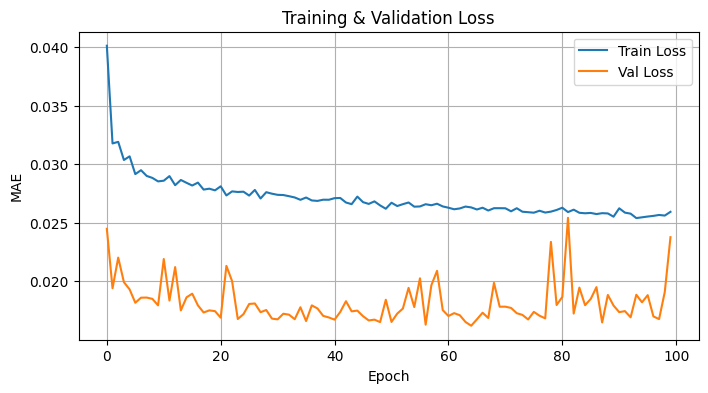

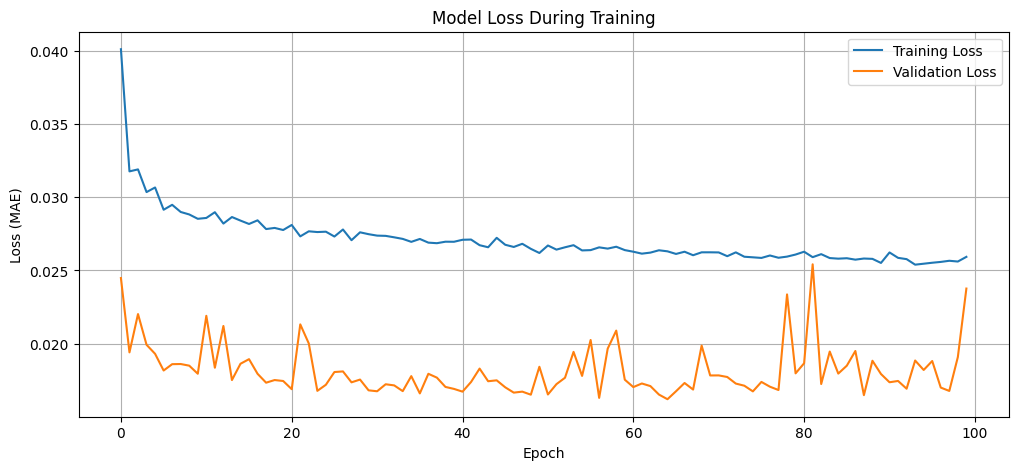

Final training loss: 0.0259
Final validation loss: 0.0238
Validation/Training loss ratio: 0.92


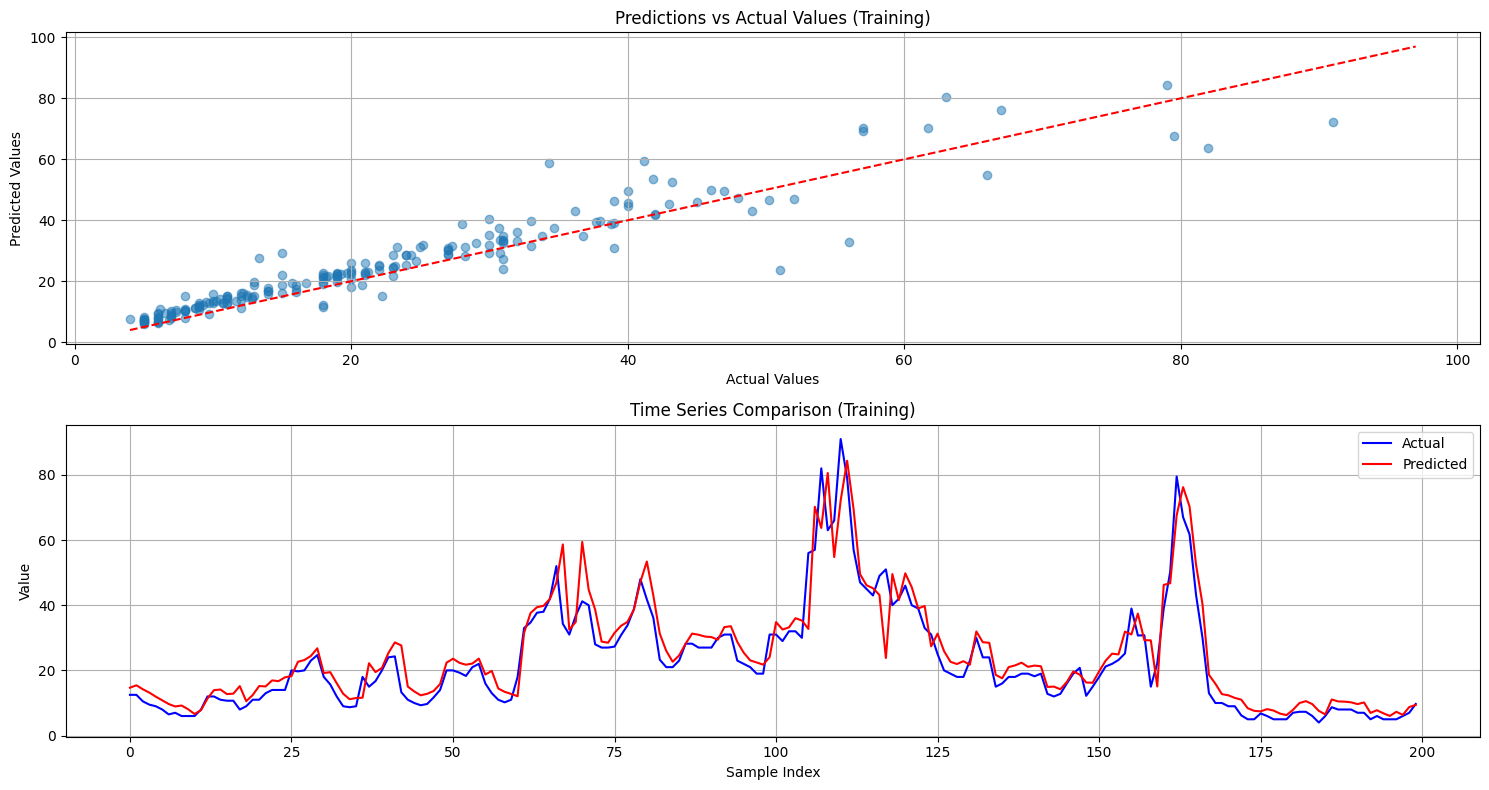

Training data metrics:
MAE: 4.0250
RMSE: 5.9376
R²: 0.8654


In [28]:
plot_loss(hist)
plot_training_history(hist)

plot_training_predictions(preds, truth, scale)